In [21]:
import sys, os
sys.path.insert(0, os.getcwd())
sys.path.insert(0, os.path.dirname(os.getcwd()))
from isi_corr import *
from random import sample

In [29]:
test_data_root = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "R_DATA_UnitMatch")
mt_path = os.path.join(test_data_root, "AL036", "19011116882", "3", "new_matchtable.csv")   
dnn_metric = "DNNSim"
um_metric = "MatchProb"
mt = pd.read_csv(mt_path)
thresh = dnn_dist.get_threshold(mt, metric=dnn_metric, vis=False)
if um_metric=="MatchProb":
    thresh_um=0.5
else:
    if um_metric=="ScoreExclCentroid":
        col = mt.loc[:, "WavformSim":"LocTrajectorySim"]
        mt[um_metric] = col.mean(axis=1)
    thresh_um = dnn_dist.get_threshold(mt, metric=um_metric, vis=False)
within = mt.loc[(mt["RecSes1"]==mt["RecSes2"]), [dnn_metric, "ISICorr", "ID1", "ID2", um_metric]]                                              # Only keep within-day bits
across = mt.loc[(mt["RecSes1"]!=mt["RecSes2"]), [dnn_metric, "ISICorr", um_metric, "RecSes1", "RecSes2", "ID1", "ID2"]]                        # Only keep across-day bits

# Correct for different median similarities between within- and across-day sets.
diff = np.median(within[dnn_metric]) - np.median(across[dnn_metric])
thresh = thresh - diff

diff_um = np.median(within[um_metric])- np.median(across[um_metric])
thresh_um = thresh_um - diff_um

matches_across = across.loc[mt[dnn_metric]>=thresh, ["ISICorr", "RecSes1", "RecSes2", "ID1", "ID2", "DNNSim"]]
non_matches = within.loc[(mt["ID1"]!=mt["ID2"]), ["ISICorr"]]
same_within = within.loc[(mt["ID1"]==mt["ID2"]), ["ISICorr"]]

um_matches = across.loc[mt[um_metric]>=thresh_um, ["ISICorr"]]

In [3]:
exp_ids, metadata = mtpath_to_expids(mt_path, matches_across)
test_data_root = mt_path[:mt_path.find(metadata["mouse"])]
positions = {}
for recses, exp_id in exp_ids.items():
    fp = os.path.join(test_data_root, metadata["mouse"], metadata["probe"], 
                        metadata["loc"], exp_id, "processed_waveforms")
    pos_dict = read_pos(fp)
    positions[recses] = pd.DataFrame(pos_dict)

In [4]:
corrections = get_corrections(matches_across, positions)

In [18]:
matches = matches_across


100%|██████████| 8/8 [00:19<00:00,  2.38s/it]


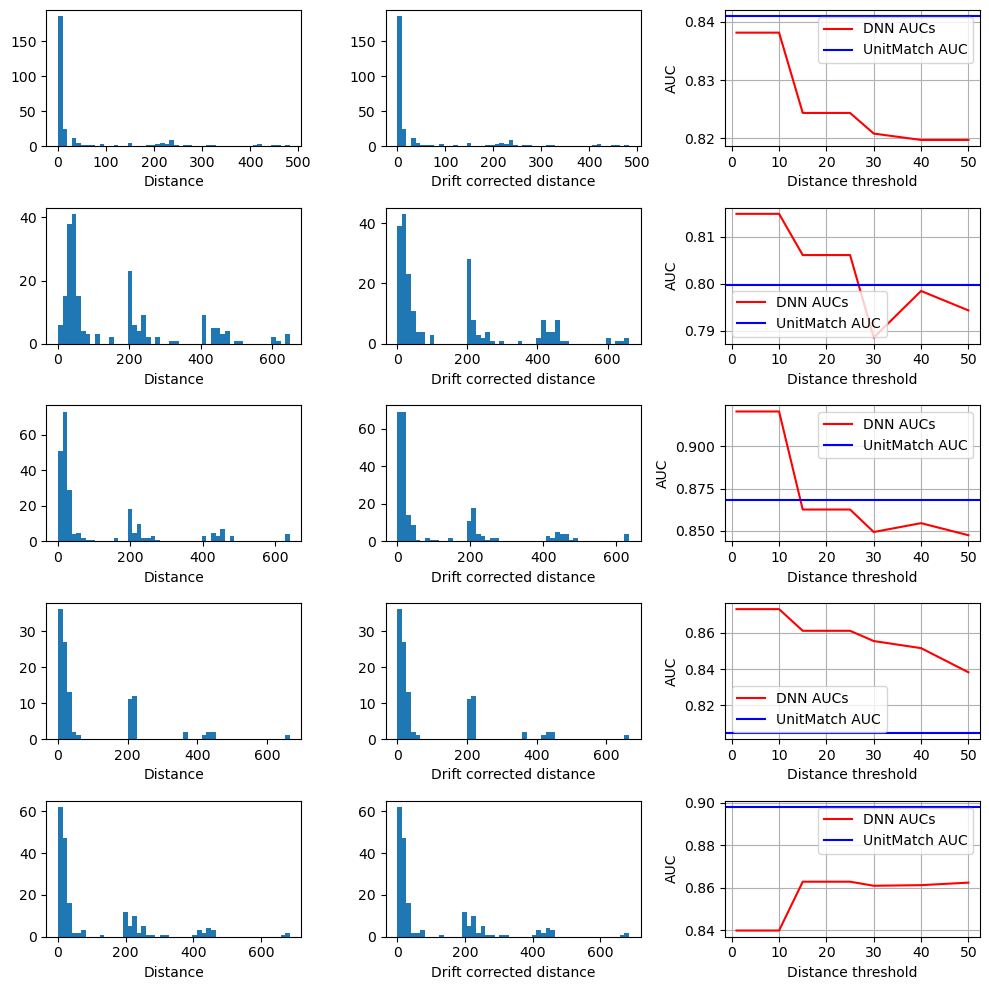

In [19]:
sessions = set(matches["RecSes1"].unique())
sessions = list(sessions.union(set(matches["RecSes2"].unique())))
mt = pd.read_csv(mt_path)
thresholds = [1,10,50,100,150,200]      # less granular
thresholds = [1,10,15,20,25,30,40,50]   # more granular
fig, axs = plt.subplots(nrows=5, ncols=3, figsize = (10,10))
i = 0
while i < 5:
    aucs = []
    r1 = sample(sessions,1)[0]
    r2 = sample(sessions,1)[0]
    while r2 == r1:
        r2 = sample(sessions,1)[0]
    for t in tqdm(thresholds):
        dnn, um = auc_one_pair(mt, r1, r2, dist_thresh=t, mt_path=mt_path)
        while dnn is None or um is None:
            r1 = sample(sessions,1)[0]
            r2 = sample(sessions,1)[0]
            while r2 == r1:
                r2 = sample(sessions,1)[0]
            dnn, um = auc_one_pair(mt, r1, r2, dist_thresh=t, mt_path=mt_path)
        aucs.append(dnn)
    dists=plot_distances(matches, positions, r1, r2, None)
    dists_dc=plot_distances(matches, positions, r1, r2, corrections)
    axs[i,0].hist(dists, bins=50)
    axs[i,0].set_xlabel("Distance")
    axs[i,1].hist(dists_dc, bins=50)
    axs[i,1].set_xlabel("Drift corrected distance")
    axs[i,2].plot(thresholds, aucs, color = "r", label="DNN AUCs")
    axs[i,2].axhline(um, label="UnitMatch AUC", color="b")
    axs[i,2].set_ylabel("AUC")
    axs[i,2].grid()
    axs[i,2].set_xlabel("Distance threshold")
    axs[i,2].legend(loc="best")
    i +=1
    fig.tight_layout()
plt.show()

In [42]:
# Plotting DNNSim against ISICorr
from scipy.stats import gaussian_kde
def plot_error_bars(matches, label):
    x = matches["DNNSim"]
    y = matches["ISICorr"]
    n_bins = 20
    bins = np.linspace(np.min(x), np.max(x), n_bins + 1)
    bin_indices = np.digitize(x, bins)
    medians, lower_err, upper_err = [], [], []
    for i in range(1, n_bins + 1):
        y_in_bin = y[bin_indices == i]
        if len(y_in_bin) > 0:
            # Compute median for this bin
            median = np.median(y_in_bin)
            medians.append(median)

            # Compute interquartile range (IQR)
            q25, q75 = np.percentile(y_in_bin, [25, 75])
            lower_err.append(median - q25)
            upper_err.append(q75 - median)
        else:
            # If bin has no data
            medians.append(np.nan)
            lower_err.append(0)
            upper_err.append(0)
    # Convert to arrays for plotting
    medians = np.array(medians)
    lower_err = np.array(lower_err)
    upper_err = np.array(upper_err)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(bin_centers, medians, yerr=[lower_err, upper_err], fmt='o', label=label, capsize=5)

samples = across.sample(10000)

density_map=False
if density_map:
    xy = np.vstack([matches["DNNSim"],matches["ISICorr"]])
    z = gaussian_kde(xy)(xy)
    plt.scatter(matches["DNNSim"], matches["ISICorr"], s=1, alpha=0.5, c=z)
else:
    plot_error_bars(samples, "Pre-spatial filtering")
    spatially_filtered = spatial_filter(mt_path, across, plot_drift=False, dist_thresh=None)
    # plot_error_bars(spatially_filtered, "After spatial filtering")
    # direction_filtered = directional_filter(across)
    # plot_error_bars(direction_filtered, label="After directional filtering")
    both = directional_filter(spatially_filtered)
    plot_error_bars(both, label="After both filters")

plt.xlabel('DNN similarity')
plt.ylabel('ISI correlation')
plt.legend()
plt.axvline(x = thresh)

  0%|          | 0/5 [00:00<?, ?it/s]

no DNN matches found!


 20%|██        | 1/5 [05:11<20:47, 311.80s/it]


KeyboardInterrupt: 

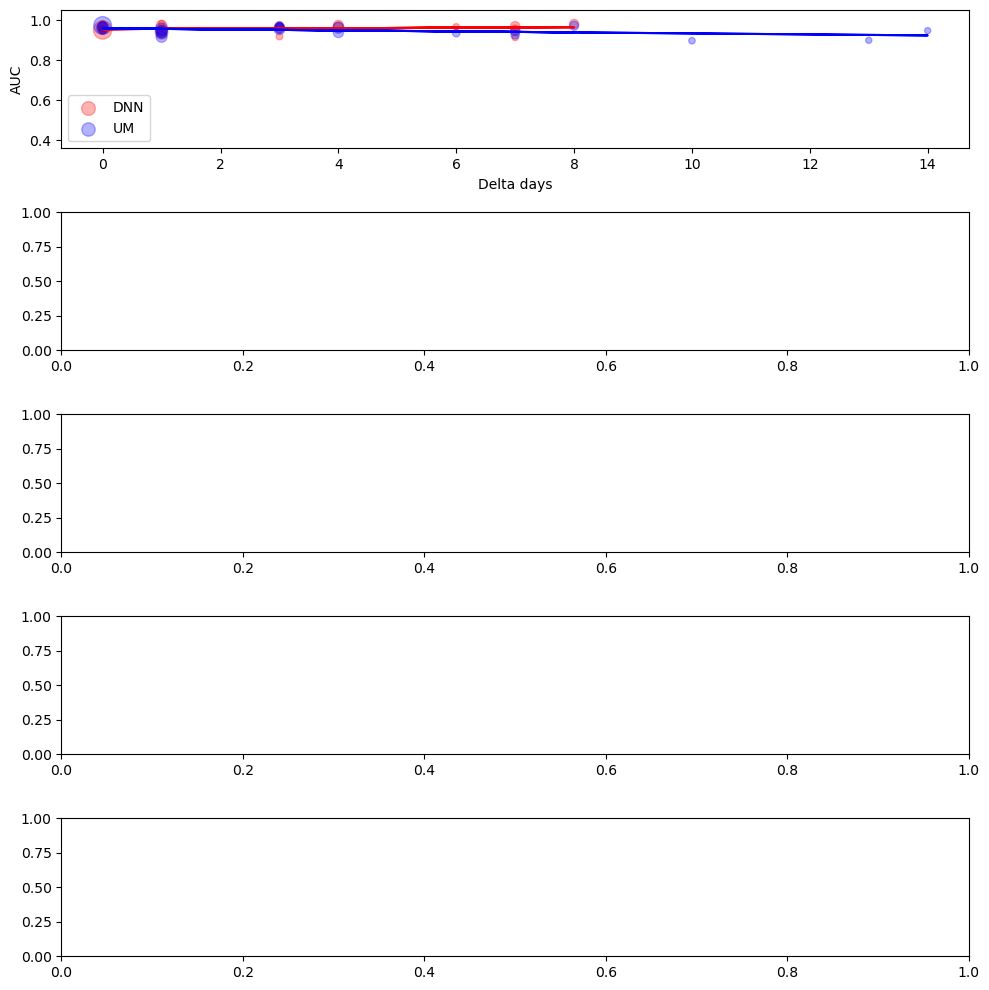

In [40]:
mt_paths = []

mt_paths.append(os.path.join(test_data_root, "AL031", "19011116684", "1", "new_matchtable.csv"))
mt_paths.append(os.path.join(test_data_root, "AL032", "19011111882", "2", "new_matchtable.csv"))
mt_paths.append(os.path.join(test_data_root, "AL036", "19011116882", "3", "new_matchtable.csv"))
mt_paths.append(os.path.join(test_data_root, "AV008", "Probe0", "IMRO_9", "new_matchtable.csv"))
mt_paths.append(os.path.join(test_data_root, "CB017", "19011110803", "2", "new_matchtable.csv"))
fig, axs = plt.subplots(nrows=5, ncols=1, figsize = (10,10))
i=0
for mt_path in tqdm(mt_paths):
    mt = pd.read_csv(mt_path)
    sessions = set(mt["RecSes1"].unique())
    dnn_auc, um_auc, delta_days_d, delta_days_u, numbers_d, numbers_u = [], [], [], [], [], []
    exp_ids,_ = mtpath_to_expids(mt_path, mt)
    for r1 in sessions:
        for r2 in sessions:
            if r1>=r2:
                continue
            dnn, um, n_dnn, n_um = auc_one_pair(mt, r1, r2, mt_path=mt_path, dist_thresh=20)
            date1 = exp_id_to_date(exp_ids[r1])
            date2 = exp_id_to_date(exp_ids[r2])
            if dnn is not None:
                dnn_auc.append(dnn)
                delta_days_d.append((date2-date1).days)
                numbers_d.append(n_dnn)
            if um is not None:
                um_auc.append(um)
                delta_days_u.append((date2-date1).days)
                numbers_u.append(n_um)
    axs[i].scatter(delta_days_d, dnn_auc, c="r", label="DNN", s=numbers_d, alpha=0.3)
    axs[i].scatter(delta_days_u, um_auc, c="b", label="UM", s=numbers_u, alpha=0.3)
    axs[i].set(xlabel="Delta days", ylabel="AUC", ylim=(0.36,1.05))
    axs[i].legend()
    model1 = LinearRegression()
    model1.fit(np.array(delta_days_d).reshape(-1,1), dnn_auc, sample_weight=numbers_d)
    line1 = model1.predict(np.array(delta_days_d).reshape(-1,1))
    model2 = LinearRegression()
    model2.fit(np.array(delta_days_u).reshape(-1,1), um_auc, sample_weight=numbers_u)
    line2 = model2.predict(np.array(delta_days_u).reshape(-1,1))
    axs[i].plot(delta_days_d, line1, label="DNN", color="r")
    axs[i].plot(delta_days_u, line2, label="UM", color="b")
    fig.tight_layout()
    i+=1
plt.show()